In [1]:
import pandas as pd
import numpy as np

In [25]:
df = pd.DataFrame.from_csv('ab_browser_test.csv', index_col=None)
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [3]:
exp_clicks = df[df.slot == 'exp']['n_clicks'].astype(float).values
control_clicks = df[df.slot == 'control']['n_clicks'].astype(float).values

print exp_clicks.sum() / control_clicks.sum()

1.0161356898244158


In [4]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [5]:
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [6]:
np.random.seed(0)

exp_median_scores = map(np.median, get_bootstrap_samples(exp_clicks, 1000))
cntr_median_scores = map(np.median, get_bootstrap_samples(control_clicks, 1000))

print "exp_median_scores",  stat_intervals(exp_median_scores, 0.05)
print "cntr_median_scores",  stat_intervals(cntr_median_scores, 0.05)

delta_median_scores = map(lambda x: x[1] - x[0], zip(exp_median_scores, cntr_median_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_median_scores, 0.05)

exp_median_scores [5. 5.]
cntr_median_scores [4. 4.]
95% confidence interval for the difference between medians [-1. -1.]


In [7]:
exp_mean_scores = map(np.mean, get_bootstrap_samples(exp_clicks, 1000))
cntr_mean_scores = map(np.mean, get_bootstrap_samples(control_clicks, 1000))

print "exp_mean_scores",  stat_intervals(exp_mean_scores, 0.05)
print "cntr_mean_scores",  stat_intervals(cntr_mean_scores, 0.05)

delta_mean_scores = map(lambda x: x[1] - x[0], zip(exp_mean_scores, cntr_mean_scores))
print "95% confidence interval for the difference between medians",  stat_intervals(delta_mean_scores, 0.05)

exp_mean_scores [11.50674915 11.65758017]
cntr_mean_scores [11.21242374 11.35449133]
95% confidence interval for the difference between medians [-0.40975645 -0.19866114]


In [33]:
print exp_clicks.mean()

11.584000994388806


In [8]:
np.random.seed(0)
n_boot_samples = 500

In [9]:
samples = get_bootstrap_samples(control_clicks, n_boot_samples)
samples.shape

(500, 284554)

In [10]:
ctrl_means = samples.mean(axis = 1)
ctrl_means.shape

(500,)

In [16]:
control_boot_chi_squared = samples.std(axis = 1)
control_boot_chi_squared.shape

(500,)

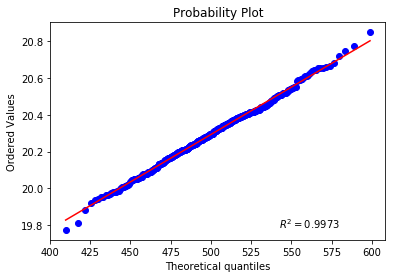

In [23]:
import scipy.stats
import matplotlib.pyplot as plt
scipy.stats.probplot(control_boot_chi_squared, dist="chi2", 
                     sparams=(n_boot_samples-1), plot=plt, rvalue = True)
plt.show()

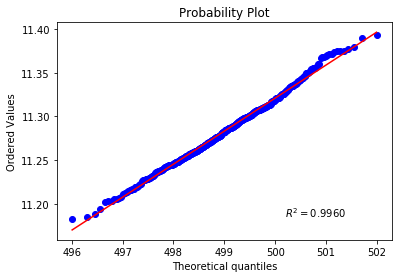

In [24]:
scipy.stats.probplot(ctrl_means, dist="norm", 
                     sparams=(n_boot_samples-1), plot=plt, rvalue = True)
plt.show()

In [65]:
exp_clicks_by_user = df[df.slot == 'exp'].groupby(['userID'])['n_clicks'].sum().values
control_clicks_by_user = df[df.slot == 'control'].groupby(['userID'])['n_clicks'].sum().values

In [66]:
print exp_clicks_by_user.shape, control_clicks_by_user.shape

(281450,) (284392,)


In [67]:
scipy.stats.mannwhitneyu(exp_clicks_by_user, control_clicks_by_user)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

In [50]:
browsers = df.browser.value_counts().index.tolist()

In [58]:
print browsers

mw_res = []

for item in browsers:
    exp_clicks_by_browser = df[(df.slot == 'exp') & (df.browser == item)]['n_clicks'].values
    control_clicks_by_browser = df[(df.slot == 'control') & (df.browser == item)]['n_clicks'].values
    mw_res.append(scipy.stats.mannwhitneyu(exp_clicks_by_browser, control_clicks_by_browser)[1])

print mw_res

['Browser #4', 'Browser #22', 'Browser #2', 'Browser #14', 'Browser #20', 'Browser #17']
[0.40760617658454984, 0.2574055152210032, 0.0272438604197241, 0.0, 0.45366656388735377, 0.03740060143010802]


In [64]:
import statsmodels.stats.multitest as smm
smm.multipletests(mw_res, method = 'holm')


(array([False, False, False,  True, False, False]),
 array([0.81521235, 0.77221655, 0.1362193 , 0.        , 0.81521235,
        0.14960241]),
 0.008512444610847103,
 0.008333333333333333)

In [62]:

for item in browsers:
    exp_br = df[(df.slot == 'exp') & (df.browser == item)]
    cntr_br = df[(df.slot == 'control') & (df.browser == item)]
    print item,
    print 100.0 * exp_br['n_nonclk_queries'].sum() / exp_br['n_queries'].sum(),
    
    print 100.0 * cntr_br['n_nonclk_queries'].sum() / cntr_br['n_queries'].sum()
    



Browser #4 45.1429419036 46.9709296351
Browser #22 39.8539472197 40.5939765935
Browser #2 44.9827469486 45.9627471792
Browser #14 43.7556173613 57.5904113601
Browser #20 38.9773764837 40.5404847434
Browser #17 36.9374128487 36.2993667463


In [63]:
print df[df.browser == browsers[3]].shape

(89123, 6)
